# Wind Farm Analysis

## Introduction

In this project, I analyse data from multiple weather stations across Ireland, treating each station as a potential location for a wind farm. The goal of this project is to showcase my ability to manipulate, analyse, and draw insights from large datasets. I will use a variety of data analysis techniques, including data cleaning, statistical analysis, visualisation, and predictive modeling, all aimed at deriving meaningful insights from the available data.

**Author:** Marcella Morgan
**Image Credit:** DALL·E 

![Irish Wind Farms](images/Irish_Wind_Farms.png)

## The Data

The weather [data](https://www.met.ie/climate/available-data/historical-data) used in this project was sourced from Met Éireann, the Irish Meteorological Service. I wanted wind speed data so I had to look at each weather station's dataset to see if it had a windspeed column. This seemed endless as there were so many, until I realised that only the bigger weather stations measured windspeed and only these ones collected hourly data - which I could filter by. I ended up with 18 datasets. The goal was to ensure comprehensive coverage of significant geographical areas.

Each station’s data was provided as a separate CSV file, and each file was contained within its own folder alongside metadata and licensing information. This meant I had to unzip and organise the files before processing them, which took forever. After that I tried to automate as much of the data handling that I could.

In [1]:
# Importing libraries 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [26]:
df = pd.read_csv('data/hly275/hly275.csv', skiprows = 17, low_memory=False)
print(df.head())
df.info()

                date  ind rain  ind.1 temp  ind.2 wetb dewpt vappr rhum msl  \
0  13-aug-2003 01:00   -1           4           4                             
1  13-aug-2003 02:00   -1           4           4                             
2  13-aug-2003 03:00   -1           4           4                             
3  13-aug-2003 04:00   -1           4           4                             
4  13-aug-2003 05:00   -1           4           4                             

   ind.3 wdsp  ind.4 wddir  
0      7           7        
1      7           7        
2      7           7        
3      7           7        
4      7           7        
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186744 entries, 0 to 186743
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    186744 non-null  object
 1   ind     186744 non-null  int64 
 2   rain    186744 non-null  object
 3   ind.1   186744 non-null  int64 
 4   temp    18674

## Automating Skipping Metadata

The weather datasets I’m working with include metadata at the top, with the actual data starting on different rows in each file. Manually checking which row the header starts on for every file and then using `skiprows` would take ages and isn’t practical.

To automate this, I wrote a function that detects the header row automatically. It looks for specific keywords ('date' and 'wdsp') that always appear in the header column names and don't appear together on a row in the metadata. Once it finds the right row, it skips all the metadata and reads the data directly from the header onwards. This also confirmed that all the datasets had a windspeed column. This [pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) helped me figure out how to do this.

Another issue I had was the name of the weather station is only in the metadata. This information is essential for analysis, but it isn’t part of the main data table. I needed a way to extract the station name from the metadata and add it as a column in the dataset. I wasn't going to do this manually.

So I wrote a function to extract the station name from the metadata. Each file contains a line like: `Station Name: MACE HEAD` at the start, so the function [searches for that specific line](https://www.statology.org/pandas-query-startswith/) and [grabs the station name](https://www.w3schools.com/python/ref_string_split.asp). To ensure consistency, the name is converted to uppercase and added as a new column `station` in the cleaned dataset. This process ensures that each row of data is tagged with the correct station name for future analysis.


In [3]:
def detect_header_row(file_path):
    """
    Detects the row number where the header starts based on the presence of 'date' and 'wdsp'.
    """
    row_number = 0  # Start counting rows
    with open(file_path, 'r') as file:
        for line in file:  # Read the file line by line
            if "date" in line.lower() and "wdsp" in line.lower(): # .lower makes it case insensitve just in case
                return row_number  # Return the current row number as the header row. This is the row number I can use for skiprows in fucntion below
            row_number += 1  # row counter goes up by one
    return None  # Return None if no valid header is found


def extract_station_name(file_path):
    """
    Extracts the station name from the first line of each csv file that starts with 'Station Name:'.
    """
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith("Station Name:"):
                # Extract the part after "Station Name:" and strip any whitespace
                return line.split("Station Name:")[1].strip().upper()  # Ensure the name is uppercase
    return None  # Return None if no station name is found


def read_clean_csv(file_path):
    """
    Reads a CSV file, skips metadata rows, and adds a 'station' column.
    """
    # Extract the station name from the metadata
    station_name = extract_station_name(file_path)

    # Detect the header row
    header_row = detect_header_row(file_path)
    if header_row is None:
        raise ValueError(f"No valid header found in {file_path}")

    # Read the data starting from the header row
    df = pd.read_csv(file_path, skiprows=header_row, low_memory=False)
    
    # Add Station Name as a column
    df['station'] = station_name
    return df


Testing fucntions with one of the files:

In [4]:
file_path = "data/hly275/hly275.csv"  # Replace with the path to one of your files

station_name = extract_station_name(file_path)
print(f"Extracted Station Name: {station_name}")

header_row = detect_header_row(file_path)
print(f"Detected Header Row: {header_row}")

cleaned_data = read_clean_csv(file_path)
print(cleaned_data.head())


Extracted Station Name: MACE HEAD
Detected Header Row: 17
                date  ind rain  ind.1 temp  ind.2 wetb dewpt vappr rhum msl  \
0  13-aug-2003 01:00   -1           4           4                             
1  13-aug-2003 02:00   -1           4           4                             
2  13-aug-2003 03:00   -1           4           4                             
3  13-aug-2003 04:00   -1           4           4                             
4  13-aug-2003 05:00   -1           4           4                             

   ind.3 wdsp  ind.4 wddir    station  
0      7           7        MACE HEAD  
1      7           7        MACE HEAD  
2      7           7        MACE HEAD  
3      7           7        MACE HEAD  
4      7           7        MACE HEAD  


## Making one Big Dataset

So it looks like the functions work!

I wanted to run the functions with each of the 18 CSV files I had. So I needed to create a list with each of the file paths. But I didn't want to do this manually. The [glob module](https://docs.python.org/3/library/glob.html) helped out here. I was able to search the data directory for the CSV files, and it even searched subdirectories within the data directory using its recursive search function [the `**` pattern](https://www.geeksforgeeks.org/how-to-use-glob-function-to-find-files-recursively-in-python/). So I could keep each CSV file in its own folder alongside its licence and other metadata.

In [5]:
import glob

# The directory I want to seach and also its subdirectories
data_path = "data/**/*.csv"  

# Get a list of all CSV files in the directory and its subdirectories
file_list = glob.glob(data_path, recursive=True)

print(file_list)  # Check the list of file paths
print(f"Number of files found: {len(file_list)}") # Checking I got all of them



['data\\hly1075\\hly1075.csv', 'data\\hly1175\\hly1175.csv', 'data\\hly1375\\hly1375.csv', 'data\\hly1475\\hly1475.csv', 'data\\hly1575\\hly1575.csv', 'data\\hly1775\\hly1775.csv', 'data\\hly1875\\hly1875.csv', 'data\\hly1975\\hly1975.csv', 'data\\hly2075\\hly2075.csv', 'data\\hly2175\\hly2175.csv', 'data\\hly2275\\hly2275.csv', 'data\\hly2375\\hly2375.csv', 'data\\hly275\\hly275.csv', 'data\\hly375\\hly375.csv', 'data\\hly575\\hly575.csv', 'data\\hly675\\hly675.csv', 'data\\hly775\\hly775.csv', 'data\\hly875\\hly875.csv']
Number of files found: 18


The next bit of code processes all the weather station files in the `file_list` by running each through the `read_clean_csv` function, which skips metadata and adds a `station` column to identify the source. The processed DataFrames are stored in the `all_data` list and then combined into a single dataset using [concat](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#concatenating-objects), creating `my_big_dataset` with all the data in one place. I ensured there would be a continuous index with the `ignore_index=True` parameter. 

Finally, the code checks the number of processed files by counting the entries in `all_data`, confirming that all files were successfully handled.


In [6]:
# Process each file in the file_list using the read_clean_csv function
all_data = [read_clean_csv(file) for file in file_list]

# Combine all processed DataFrames into one
my_big_dataset = pd.concat(all_data, ignore_index=True,)

# Checking all 18 files were processed
print(f"Number of processed files: {len(all_data)}")

#Saving as CSV file
#my_big_dataset.to_csv("my_big_dataset.csv", index=False)



Number of processed files: 18


## Cleaning My Big Dataset

I ended up with a dataset that had over 5 million rows. So I printed it out and sat down at the kitchen table with a pencil and ruler so I could check each row for any issues. Just kidding! I didn't do that. Instead I used some handy code to figure out what kind of data I was dealing with.

In [7]:
print(my_big_dataset)

# Checking the structure of the data
print(my_big_dataset.info())

# Check for missing values
print(my_big_dataset.isnull().sum())


                      date  ind rain  ind.1  temp  ind.2  wetb dewpt vappr  \
0        01-dec-1955 01:00    0  0.0      0  10.7      0  10.0   9.4  11.8   
1        01-dec-1955 02:00    0  2.9      0   9.8      0   9.7  10.0  12.0   
2        01-dec-1955 03:00    0  3.8      0   9.7      0   9.5   9.4  11.7   
3        01-dec-1955 04:00    0  0.8      0   9.8      0   9.7   9.4  11.9   
4        01-dec-1955 05:00    0  0.3      0   8.9      0   8.7   8.3  11.1   
...                    ...  ...  ...    ...   ...    ...   ...   ...   ...   
5745370  30-nov-2024 20:00    0  0.0      0  13.5      0  12.7  12.0  14.0   
5745371  30-nov-2024 21:00    0  0.0      0  13.5      0  12.7  12.0  14.0   
5745372  30-nov-2024 22:00    0  4.1      0  12.1      0  11.7  11.4  13.5   
5745373  30-nov-2024 23:00    0  0.0      0  12.3      0  11.9  11.6  13.7   
5745374  01-dec-2024 00:00    0  0.0      0  12.3      0  11.8  11.4  13.4   

        rhum  ... wdsp  ind.4 wddir       station   ww    w  su

## Cleaning Up Missing Values

I focused on cleaning up the missing values in the dataset. Most of the original datasets had 16 columns, but a few stations included 5 additional columns. This introduced missing values when the datasets were merged, so it made sense that the last five columns - the extra columns from the larger weather stations - had nearly 4 million missing values. Fortunately, `pandas.concat` [automatically converted](https://pyimagesearch.com/2024/05/07/using-pandas-concat-pd-concat/) these blanks into `np.nan` values, which are [recognised by pandas and numpy](https://www.askpython.com/python/examples/nan-in-numpy-and-pandas) as missing vaules so they don't cause problems with calculations. These `np.nan` values are floats, which affects columns with int values - more on this later.

However, when I inspected the other columns, `pandas` was reporting 0 missing values, which didn’t match what I saw when scrolling through `my_big_dataset.csv`. The issue was that some missing values were misrepresented as empty strings. They weren’t being recognised as missing values but as blank text, and this would cause problems during analysis. 

Another related issue was that most of the columns containing integers were [being read as `object` type](https://www.geeksforgeeks.org/pandas-detect-mixed-data-types-and-fix-it/). This might have happened because `pandas` was trying to handle the mix of integers and empty strings in those columns. 

To fix this, I wanted to replace all empty strings with `np.nan` using [`replace`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html). But I needed to find out first how exactly the missing values were being represented.


In [8]:
# Check unique values in a column
print(my_big_dataset['wdsp'].unique())

['16' '11' '9' '5' '12' '15' '13' '14' '7' '4' '3' '6' '1' '0' '21' '19'
 '23' '22' '20' '8' '2' '17' '18' '10' '25' '29' '26' '24' '27' '28' '30'
 '31' '36' '32' '33' '34' '40' '41' '42' '38' '35' '46' '48' '44' '37'
 '39' '43' '47' '50' '53' '54' '45' '51' '55' '49' '52' '59' '56' ' ' '62'
 '60' '57' '63' '61' '58' '97']


So the missing values were being represented as " "

In [9]:
# Replace all empty strings with NaN in the dataset
my_big_dataset.replace(" ", np.nan, inplace=True)

# Verify the change by checking for missing values
print(my_big_dataset.isnull().sum())
print(my_big_dataset.info())

date             0
ind              0
rain        110833
ind.1            0
temp         30409
ind.2            0
wetb         42486
dewpt        41501
vappr       184823
rhum        163718
msl          71928
ind.3            0
wdsp         83644
ind.4            0
wddir        95840
station          0
ww         4178060
w          4178059
sun        4177877
vis        4178224
clht       4178129
clamt      4178129
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5745375 entries, 0 to 5745374
Data columns (total 22 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   date     object
 1   ind      int64 
 2   rain     object
 3   ind.1    int64 
 4   temp     object
 5   ind.2    int64 
 6   wetb     object
 7   dewpt    object
 8   vappr    object
 9   rhum     object
 10  msl      object
 11  ind.3    int64 
 12  wdsp     object
 13  ind.4    int64 
 14  wddir    object
 15  station  object
 16  ww       object
 17  w        object
 18  sun      object
 19  vis      o

I was still getting the rows with numeric values being read as objects. This might be becasue `np.nan` is a float so the columns now had a mix of ints and float values. I wanted them to be read as numeric at least so I could do calculations with them. So I decided to [convert](https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html) them using `to_numeric`. 

I also converted the `date` column to a proper datetime format for easier analysis and consistency. It was taking forever to convert to datetime. I stopped running the code after 10mins. So I went googling and I found [this thread](https://stackoverflow.com/questions/32034689/why-is-pandas-to-datetime-slow-for-non-standard-time-format-such-as-2014-12-31) that explained that it would be quicker if I gave pandas the format for the date column - so it wouldn't have to go looking for it and it did it in a minute. Still a bit slow but managable. 

In [10]:
# Converting all columns excpept 'data' and 'station' to numeric
columns_to_convert = [col for col in my_big_dataset.columns if col not in ['station', 'date']]
my_big_dataset[columns_to_convert] = my_big_dataset[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert the date column to datetime
my_big_dataset['date'] = pd.to_datetime(my_big_dataset['date'], format='%d-%b-%Y %H:%M')

# Check the cleaned data
print(my_big_dataset.info())
print(my_big_dataset.isnull().sum())
print(my_big_dataset.dtypes)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5745375 entries, 0 to 5745374
Data columns (total 22 columns):
 #   Column   Dtype         
---  ------   -----         
 0   date     datetime64[ns]
 1   ind      int64         
 2   rain     float64       
 3   ind.1    int64         
 4   temp     float64       
 5   ind.2    int64         
 6   wetb     float64       
 7   dewpt    float64       
 8   vappr    float64       
 9   rhum     float64       
 10  msl      float64       
 11  ind.3    int64         
 12  wdsp     float64       
 13  ind.4    int64         
 14  wddir    float64       
 15  station  object        
 16  ww       float64       
 17  w        float64       
 18  sun      float64       
 19  vis      float64       
 20  clht     float64       
 21  clamt    float64       
dtypes: datetime64[ns](1), float64(15), int64(5), object(1)
memory usage: 964.3+ MB
None
date             0
ind              0
rain        110833
ind.1            0
temp         30409
ind.2  

## Average Windspeed and Standard Deviation

I wanted to take a quick look at which of the weather stations were the windiest. So I calculated the monthly average windspeed for each station. Pandas [`mean`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mean.html) function skips `nan` by default. I then plotted a line graph using seaborn, which let me use the [`hue`](https://seaborn.pydata.org/generated/seaborn.lineplot.html) parameter to display each station's mean as its own line. 

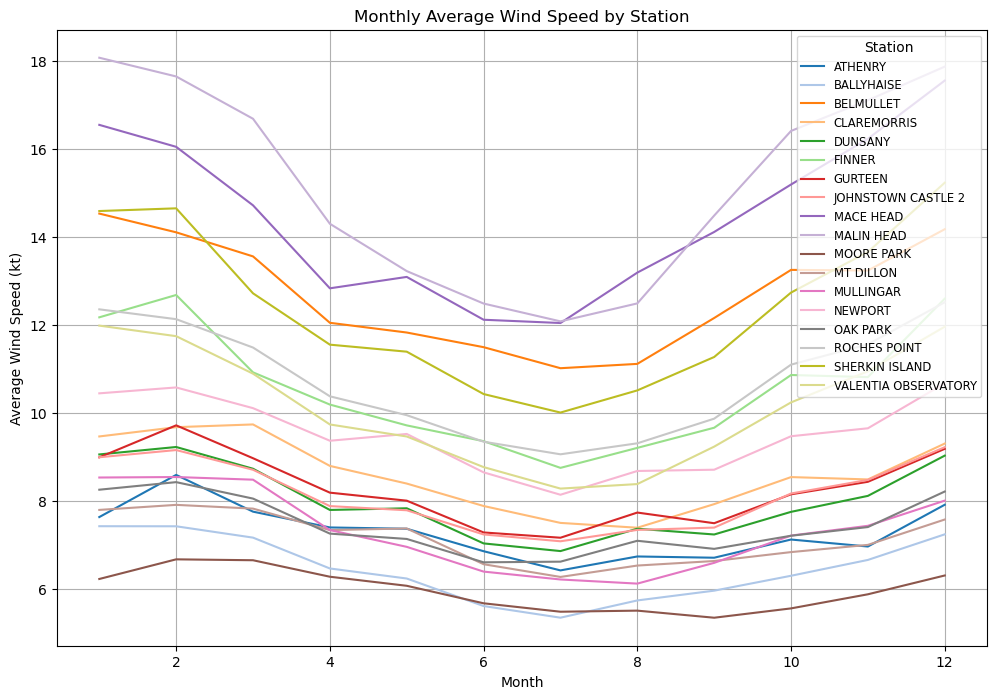

In [11]:
# Extracting the month from the 'date' column and adding it as a new column
my_big_dataset['month'] = my_big_dataset['date'].dt.month

# Grouping the dataset by 'station' and 'month', then calculate the mean wind speed ('wdsp')
monthly_means = my_big_dataset.groupby(['station', 'month'])['wdsp'].mean().reset_index()

# Create a line plot with seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(data=monthly_means, x='month', y='wdsp', hue='station', palette='tab20' )

# Add titles and labels
plt.title("Monthly Average Wind Speed by Station")
plt.xlabel("Month")
plt.ylabel("Average Wind Speed (kt)")
plt.legend(title="Station", loc="upper right", fontsize='small')
plt.grid()

plt.show()


So I could see Mace and Malin Head were the windiest stations. But I wanted to look closer at the variability in windspeed. As this is an important factor in deciding on locations for wind farms. So I found the standard deviation for each station using [`pd.std`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.std.html) and then displayed it as a bar chart.

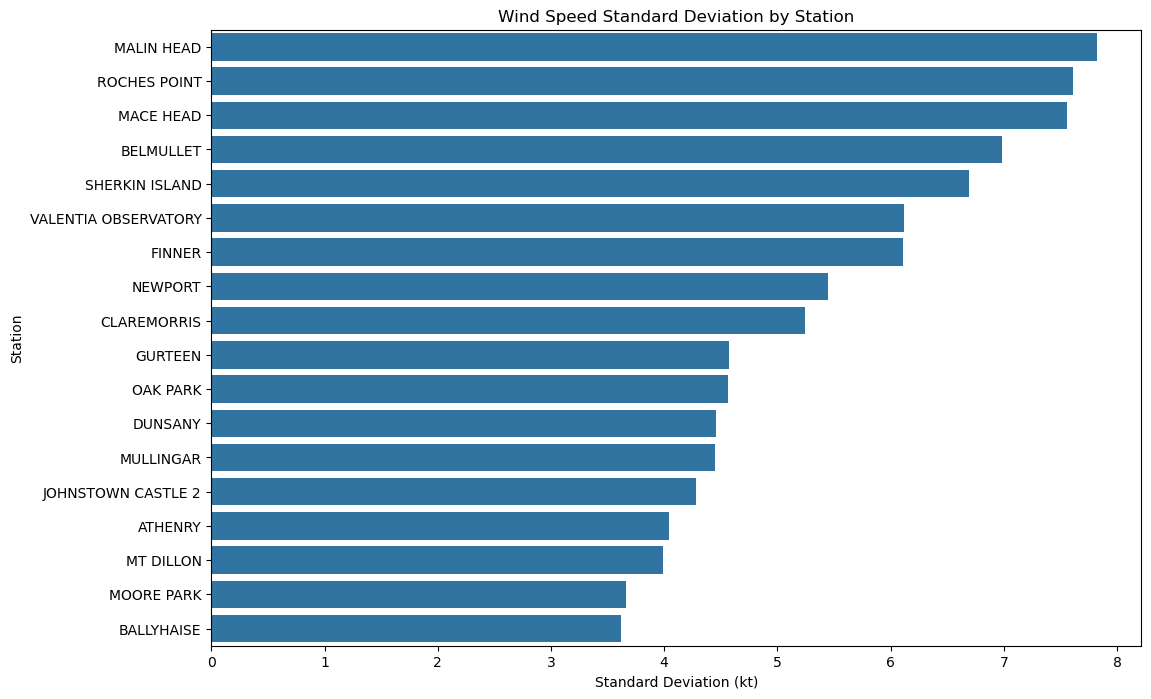

In [12]:
# Group by station and calculate the standard deviation for 'wdsp'
std_by_station = my_big_dataset.groupby('station')['wdsp'].std().reset_index()
# Rename columns for clarity
std_by_station.columns = ['station', 'std_wind_speed']

# Sort the DataFrame by standard deviation in descending order
std_by_station = std_by_station.sort_values(by='std_wind_speed', ascending=False)

# Create a horizontal bar chart
plt.figure(figsize=(12, 8))
sns.barplot(data=std_by_station, x='std_wind_speed', y ='station')

# Add titles and labels
plt.title("Wind Speed Standard Deviation by Station")
plt.xlabel("Standard Deviation (kt)")
plt.ylabel("Station")

plt.show()



So it looks like the stations with the highest windspeeds are also the stations with the most deviation. I was interested in the time period for the variation. It was clear from the average windspeed graph that the speed varied throughout the year, with windspeeds during the summer being lower. But was there daily variation and how did that compare to yearly variation? 

This matters because a location that has steady windspeeds that drop during the summer would be different than a location that has varying windspeeds throughout the day. 

In [13]:
# Add columns for day
my_big_dataset['day'] = my_big_dataset['date'].dt.date

# Calculate daily and monthly standard deviation per station
daily_std = my_big_dataset.groupby(['station', 'day'])['wdsp'].std().reset_index()
monthly_std = my_big_dataset.groupby(['station', 'month'])['wdsp'].std().reset_index()

# Calculate the average daily and monthly standard deviation for each station
daily_std_by_station = daily_std.groupby('station')['wdsp'].mean().reset_index()
daily_std_by_station.columns = ['station', 'avg_daily_std']
monthly_std_by_station = monthly_std.groupby('station')['wdsp'].mean().reset_index()
monthly_std_by_station.columns = ['station', 'avg_monthly_std']

# Merge the two datasets
std_combined = daily_std_by_station.merge(monthly_std_by_station, on='station')


I sorted daily variation highest to lowest and combined with the yearly variation. This helped see which stations had high daily variation compared to yearly variation.

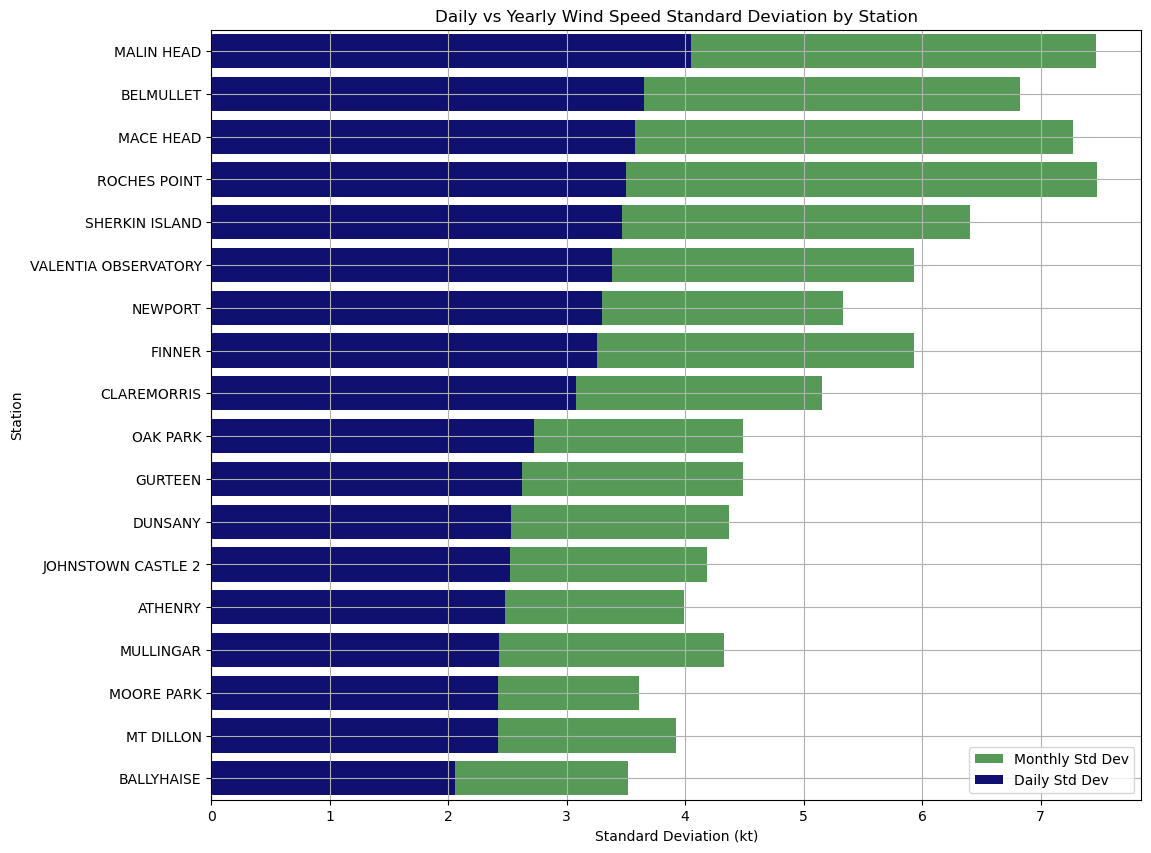

In [ ]:
# Bar chart comparison - want to show the highest daily variation to lowest
std_combined_sorted = std_combined.sort_values(by='avg_daily_std', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(data=std_combined_sorted, y='station', x='avg_monthly_std', color='green', alpha=0.7, label='Monthly Std Dev')
sns.barplot(data=std_combined_sorted, y='station', x='avg_daily_std', color='navy', label='Daily Std Dev')

plt.title("Daily vs Yearly Wind Speed Standard Deviation by Station")
plt.ylabel("Station")
plt.xlabel("Standard Deviation (kt)")
plt.legend()
plt.grid()

plt.show()


I want to compare the yearly and daily standard deviation with the average windspeed so I did a scatterplot to show all three variables. I was able to use seaborn's very handy `hue` and [`size`](https://seaborn.pydata.org/generated/seaborn.scatterplot.html) functions so I could also represent each station.

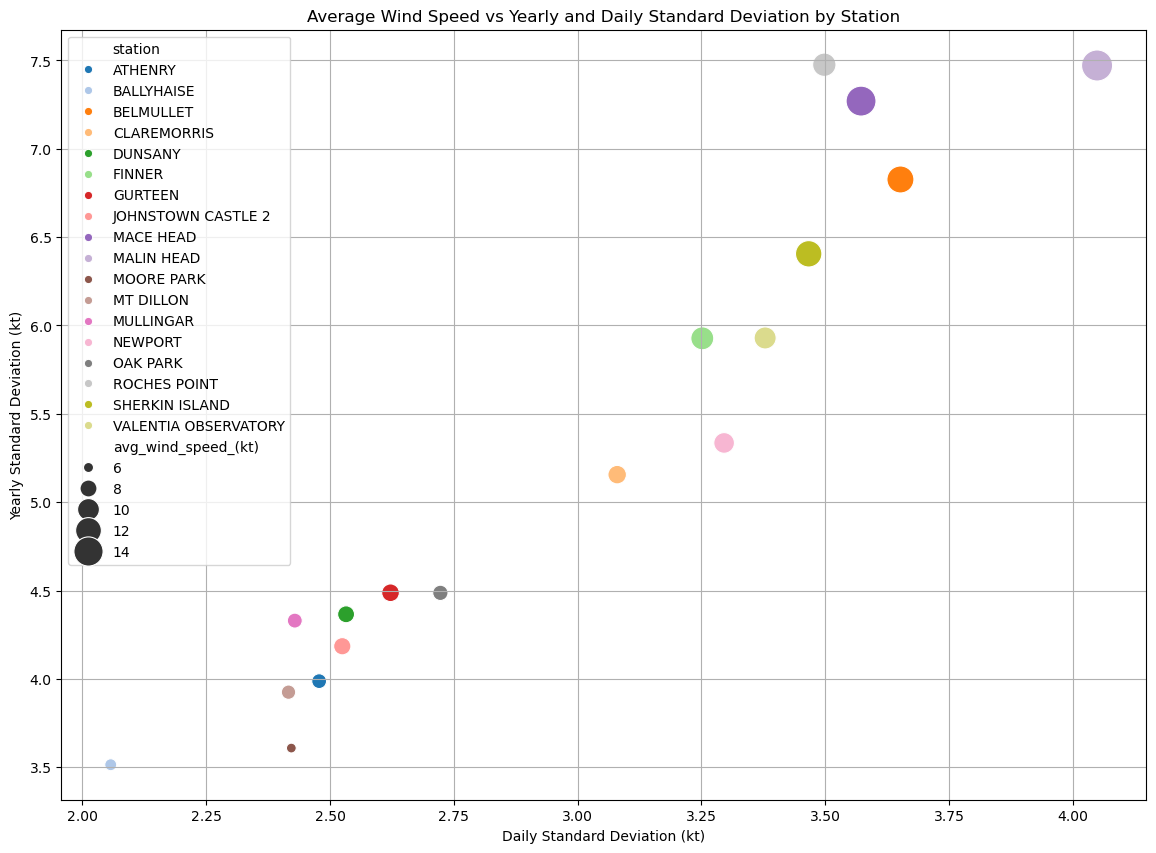

In [15]:
# Calculate average wind speed by station
avg_wind_speed = my_big_dataset.groupby('station')['wdsp'].mean().reset_index()
avg_wind_speed.columns = ['station', 'avg_wind_speed_(kt)']

# Merge with the std_combined DataFrame
std_combined = std_combined.merge(avg_wind_speed, on='station')

plt.figure(figsize=(14, 10))
sns.scatterplot(data=std_combined, x='avg_daily_std', y='avg_monthly_std', hue='station', size='avg_wind_speed_(kt)', sizes=(50, 500), palette='tab20')
plt.title("Average Wind Speed vs Yearly and Daily Standard Deviation by Station")
plt.xlabel("Daily Standard Deviation (kt)")
plt.ylabel("Yearly Standard Deviation (kt)")
plt.legend
plt.grid()
plt.show()


My scatterplot looked very fancy but it wasn't really telling me anything that I couldn't see from the other graphs. It seems that daily and yearly variability increase as windspeed increases with some exceptions. Bellmullet seems to have high daily variability relative to its average windspeeds. Roches point has very high daily and yearly variability compared to stations with similar windspeeds.

I decided to compare the power output of Roches Point and Finner. I thought it would be interesting to see how much their power output differed given that they had similar windspeeds but Roches Point had higher variability. I also thought it would be interesting to see how the difference in daily variability between Mace Head and Malin Head would be reflected in their power output, given their windspeeds were similar.

I decided to focus on one year - 2023. So I needed to make sure all the stations I was working with had data for that year.

In [16]:
# Extracting the year from the 'date' column
my_big_dataset['year'] = my_big_dataset['date'].dt.year

# Filter the dataset for rows with the year 2023
data_2023 = my_big_dataset[my_big_dataset['year'] == 2023]['station'].unique()

# Display the stations
print("Stations with 2023 data:")
print(data_2023)

Stations with 2023 data:
['ROCHES POINT' 'NEWPORT' 'DUNSANY' 'GURTEEN' 'MALIN HEAD'
 'JOHNSTOWN CASTLE 2' 'ATHENRY' 'MT DILLON' 'FINNER' 'CLAREMORRIS'
 'VALENTIA OBSERVATORY' 'BELMULLET' 'MACE HEAD' 'OAK PARK' 'MOORE PARK'
 'BALLYHAISE' 'SHERKIN ISLAND' 'MULLINGAR']


## Power Output Comparisons

The power generated by a wind turbine can be calculated using the [formula](https://www.e-education.psu.edu/emsc297/node/649):

P = (1/2) * ρ * A * v³

Where:
- **P**: Power output (Watts).
- **ρ**: Air density.
- **A**: Rotor swept area (e.g., πr², where r is the blade radius).
- **v**: Wind speed (m/s).

Becasue the windspeed values are given in knots, I needed to convert them to meters per second before doing the power output calculation. I set the blade diameter at 50m as this is a common blade diameter for windmills in Ireland.

In [17]:
# Filter for stations and 2023 data
stations_to_compare = ['ROCHES POINT', 'FINNER', 'MACE HEAD', 'MALIN HEAD']
comparison_data = my_big_dataset[
    (my_big_dataset['year'] == 2023) & 
    (my_big_dataset['station'].isin(stations_to_compare))
].copy()

# Constants for power calculation
blade_radius = 25  # meters - half diameter
blade_area = np.pi * blade_radius**2  # Rotor swept area

# Convert wind speed to m/s if not already done
comparison_data['wdsp_m_s'] = comparison_data['wdsp'] * 0.514444

# Calculate power output
comparison_data['power_output'] = 0.5 * comparison_data['msl'] * blade_area * (comparison_data['wdsp_m_s'] ** 3)

# Group by station and total power generation
station_power_generation = comparison_data.groupby('station')['power_output'].sum().reset_index()
station_power_generation.columns = ['Station', 'Total Power Generation (Watts)']

print(station_power_generation)



        Station  Total Power Generation (Watts)
0        FINNER                    2.463074e+12
1     MACE HEAD                    6.636104e+12
2    MALIN HEAD                    6.351319e+12
3  ROCHES POINT                    4.135377e+12


So as expected the station with the highest windspeeds would produce the most power. But lets take a closer look at the daily average power generation of each of the stations.

In [18]:
# Extract hour from the datetime column
comparison_data['hour'] = comparison_data['date'].dt.hour

# Group by station and hour, then calculate the average power output
hourly_avg_power = comparison_data.groupby(['station', 'hour'])['power_output'].mean().reset_index()

# Rename columns for clarity
hourly_avg_power.columns = ['Station', 'Hour', 'Average Hourly Power Output (Watts)']
print (hourly_avg_power)


         Station  Hour  Average Hourly Power Output (Watts)
0         FINNER     0                         2.362439e+08
1         FINNER     1                         2.343403e+08
2         FINNER     2                         2.270714e+08
3         FINNER     3                         2.281989e+08
4         FINNER     4                         2.289552e+08
..           ...   ...                                  ...
91  ROCHES POINT    19                         5.081482e+08
92  ROCHES POINT    20                         4.723278e+08
93  ROCHES POINT    21                         4.153643e+08
94  ROCHES POINT    22                         3.972121e+08
95  ROCHES POINT    23                         4.075543e+08

[96 rows x 3 columns]


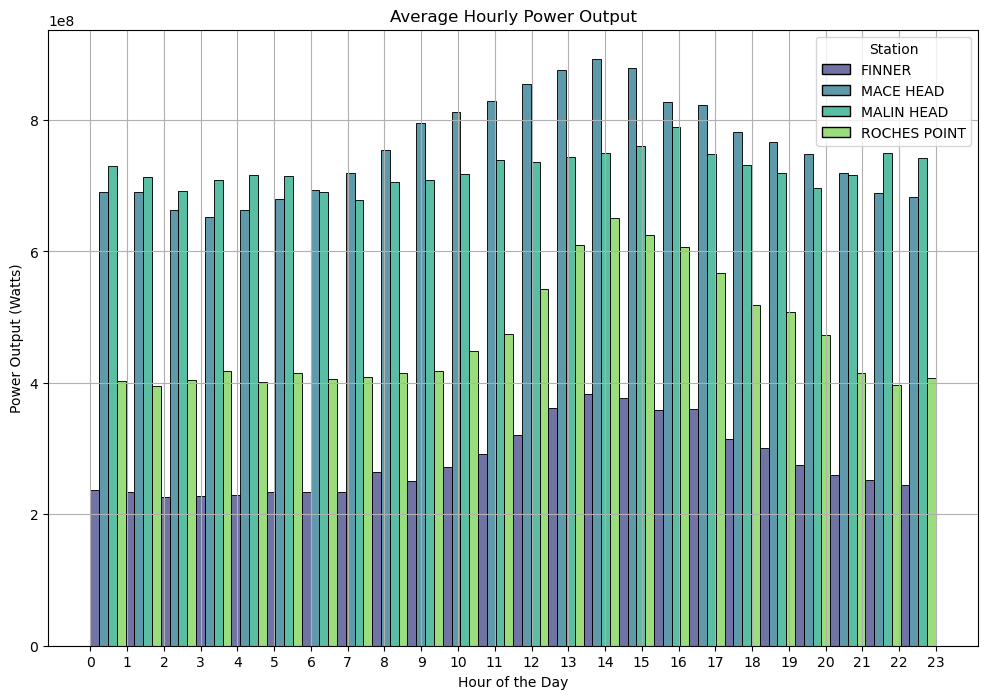

In [19]:
# Plot the histogram
plt.figure(figsize=(12, 8))
sns.histplot(
    data=hourly_avg_power,
    x='Hour',
    weights='Average Hourly Power Output (Watts)',  # Use weights to reflect power output
    hue='Station',
    bins=24,  # One bin per hour
    multiple='dodge',  # Separate bars for each station
    palette='viridis',
)

plt.title("Average Hourly Power Output")
plt.xlabel("Hour of the Day")
plt.ylabel("Power Output (Watts)")
plt.xticks(range(0, 24))  # Ensure x-axis shows all hours
plt.grid()
plt.show()



### Conclusion: Power Output and Variability Analysis

The comparison of power output and variability between each potential windfarm location, revealed distinct differences in performance:

1. **Power Output**:
   - Mace Head consistently produced the highest total power output for 2023, driven by strong and consistent winds.
   - Finner, while exhibiting lower wind speeds overall, demonstrated steady performance with less variability, contributing to more predictable energy output.

2. **Variability**:
   - Roches Point exhibited higher variability in daily power generation compared to Finner. This highlights the impact of wind speed fluctuations on energy output, which can complicate power grid integration.

3. **Insights**:
   - Stations with higher wind speeds generally produce more power, as expected. However, the degree of variability in wind speed and power generation can significantly impact the stability and predictability of energy supply.

This analysis underscores the importance of not just maximizing wind speeds for power generation, but also considering variability when evaluating wind farm efficiency and reliability. 

Also really interesting that all four stations - locacted in both the north and south of the country - showed an increase in power production (so I'm assuming windspeed) in the afternoon. I've never noticed that it's windier in the afternoon!

## Predicting the Future

For this part of the project, I decided to focus on Mace Head station to keep things simple and to explore the relationship between time and wind speed at a single location. I used [SciKit-learn](https://scikit-learn.org/stable/) to predict wind speed trends over time and into the future.

For simplicity, I’ve created a `time_index` that represents the order of observations in the dataset rather than using actual datetime values. The `time_index` is a [sequential number](https://stackoverflow.com/questions/52542408/converting-a-datetime-index-value-to-an-index-number), starting at 0 for the first observation and increasing by 1 for each subsequent entry. While it doesn’t correspond to specific dates or times, it allows me to analyze general trends in wind speed over the dataset’s timeline. Using actual datetime values would require converting them into a numeric format, which adds complexity without significantly changing the trend analysis.

In [20]:
# Filter data for Mace Head and start regression at time_index 4000
mace_head_data = comparison_data[comparison_data['station'] == 'MACE HEAD'].copy()

# Add a sequential time index (assuming data is time-ordered)
mace_head_data['time_index'] = range(len(mace_head_data))

# Filter data to start from time_index 4000
mace_head_data = mace_head_data[mace_head_data['time_index'] >= 4000]



The idea here is to train the model on data from the latter half of the observations (starting at `time_index = 4000`) and then use it to predict wind speeds for future indices (up to `time_index = 12000`). This approach essentially looks at the historical trend in the dataset and assumes it will continue into the future.

While this is a very basic way to predict trends, it’s a good way to experiment with regression and see how well the model captures patterns in the data. The resulting graph shows both the observed wind speeds and the predicted future values, which helps to visualise how consistent or variable the wind speeds might be over time. This isn't meant to be a realistic forecast—more a way to showcase how linear regression works with time-series-like data.


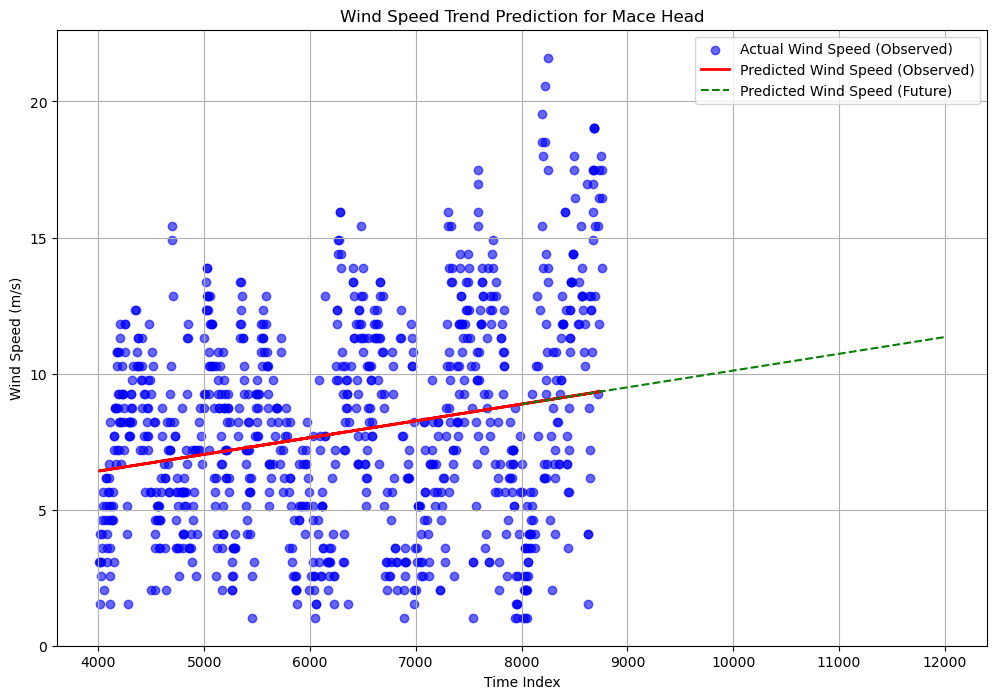

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Define features (time_index) and target (wind speed)
X = mace_head_data[['time_index']]
y = mace_head_data['wdsp_m_s'] 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Create future time indices (e.g., 8001 to 12000)
future_time_index = pd.DataFrame({'time_index': range(8001, 12001)})

# Predict wind speeds for future indices
future_predictions = model.predict(future_time_index)

# Combine predictions with the time index
future_trends = future_time_index.copy()
future_trends['predicted_wind_speed'] = future_predictions

plt.figure(figsize=(12, 8))

# Plot existing data predictions
plt.scatter(X_test, y_test, color='blue', label='Actual Wind Speed (Observed)', alpha=0.6)
plt.plot(X_test, y_pred, color='red', label='Predicted Wind Speed (Observed)', linewidth=2)

# Plot future predictions
plt.plot(future_trends['time_index'], future_trends['predicted_wind_speed'], color='green', linestyle='--', label='Predicted Wind Speed (Future)')

plt.title("Wind Speed Trend Prediction for Mace Head")
plt.xlabel("Time Index")
plt.ylabel("Wind Speed (m/s)")
plt.legend()
plt.grid()
plt.show()


So it looks like it's only going to get windier. I'll have to give up on umbrellas altogether!

## Conclusion

This project was all about taking data from weather stations across Ireland and analysing it as if each station were a potential location for a wind farm. While I’m definitely not an expert in wind farm planning, the goal was to showcase my ability to manipulate, analyse, and draw insights from large datasets.

Throughout the project, I worked with wind speed, air pressure, and power output data, exploring trends and variability. I compared stations like Roches Point and Finner to highlight differences in power generation and variability, which could impact the reliability of energy production. I also used linear regression to predict wind speed trends at Mace Head, dipping my toes into predictive modelling to demonstrate a more advanced analysis technique.

The key takeaway is that while high wind speeds are essential for power generation, variability plays a big role in determining a station’s suitability for a wind farm. Consistent winds lead to more predictable energy output, which is often just as important as the overall power potential. 

Overall, this project has been a great way to apply data analysis techniques, from cleaning and exploring the data to performing more advanced modelling and creating visualisations to communicate findings. It’s shown how much can be learned from a dataset with the right tools and a bit of curiosity.


## END